<h1><center>Проект Отток клиентов</center></h1>


# Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

# Описание данных

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


    Признаки:

        RowNumber — индекс строки в данных

        CustomerId — уникальный идентификатор клиента

        Surname — фамилия

        CreditScore — кредитный рейтинг

        Geography — страна проживания

        Gender — пол

        Age — возраст

        Tenure — количество недвижимости у клиента

        Balance — баланс на счёте

        NumOfProducts — количество продуктов банка, используемых клиентом

        HasCrCard — наличие кредитной карты

        IsActiveMember — активность клиента

        EstimatedSalary — предполагаемая зарплата


    Целевой признак:

        Exited — факт ухода клиента

# Содержание


    1. Подготовка данных

    2. Исследование модели без учета дисбаланса классов

    3. Борьба с дисбалансом

    4. Тестирование модели

    5. Общий вывод

<div style="border:solid black 1.5px; padding: 20px">
    
- Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score, auc, roc_curve
from sklearn.utils import shuffle

import warnings


# 1. Подготовка данных

<div style="border:solid black 1.5px; padding: 20px">

- Загрузим и рассмотрим датасет

In [2]:
churn = pd.read_csv('/datasets/Churn.csv')

churn.info()

display(churn)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


<div style="border:solid black 1.5px; padding: 20px">

- Перед нами множество количественных и качественных признаков


- Пропущенные зачения наблюдаются только в столбце Tenure - количество недвижимости у клиента


- Мы можем заменить соответствующие значения Nan на 0 и дополнительно привести формат к целочисленному

In [3]:
churn['Tenure'] = churn['Tenure'].fillna(0).astype('int64')

churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


# 2. Исследование задачи

<div style="border:solid black 1.5px; padding: 20px">

    
- Перед нами поставлена задача классификации: необходимо по имеющимся признакам предсказать возможность ухода клиента из банка

<div style="border:solid black 1.5px; padding: 20px">

    
- Рассмотрим имеющиеся признаки для обучения и целевой признак
    
    
- __Признаки:__


        RowNumber — индекс строки в данных

        CustomerId — уникальный идентификатор клиента

        Surname — фамилия

        CreditScore — кредитный рейтинг

        Geography — страна проживания

        Gender — пол

        Age — возраст

        Tenure — количество недвижимости у клиента

        Balance — баланс на счёте

        NumOfProducts — количество продуктов банка, используемых клиентом

        HasCrCard — наличие кредитной карты

        IsActiveMember — активность клиента

        EstimatedSalary — предполагаемая зарплата

    
- __Целевой признак:__

        Exited — факт ухода клиента

<div style="border:solid black 1.5px; padding: 20px">

    
- Очевидно, такие признаки как: 
    
        RowNumber — индекс строки в данных

        CustomerId — уникальный идентификатор клиента

        Surname — фамилия
    
    не имеют никакого отношения к вероятности ухода клиента из банка, поэтому в обучении модели мы не будем их использовать

In [4]:
churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


<div style="border:solid black 1.5px; padding: 20px">

    
- Оценим корреляции между количественными признками, чтобы при необходимости убрать излишние

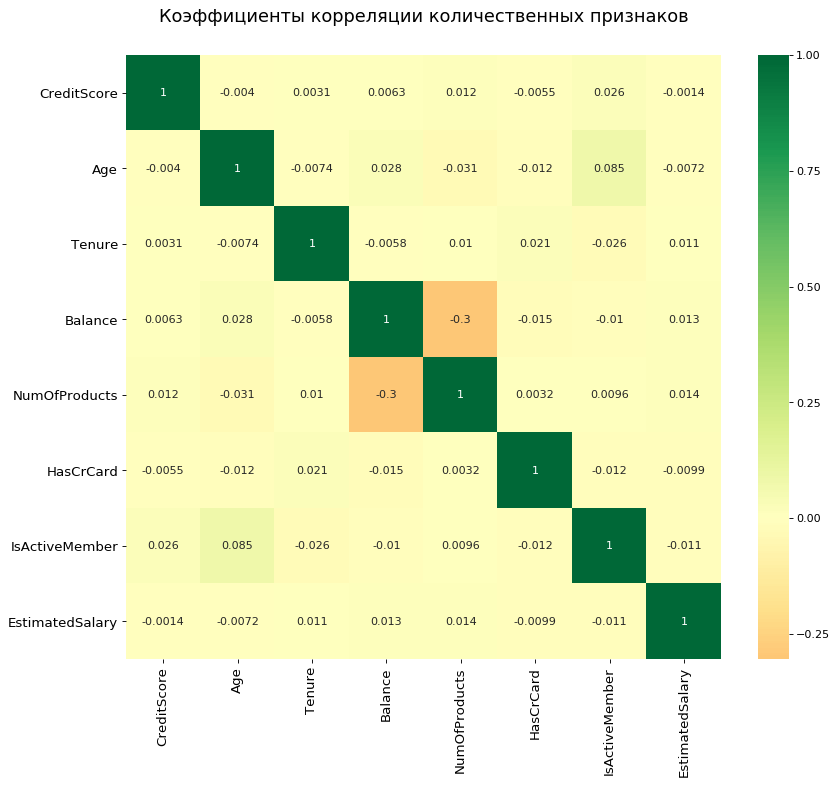

In [5]:
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# Plot
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(churn[numerical_columns].corr(), xticklabels=churn[numerical_columns].corr().columns, yticklabels=churn[numerical_columns].corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Коэффициенты корреляции количественных признаков', fontsize=16, pad=30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<div style="border:solid black 1.5px; padding: 20px">

    
- Существенной корреляции между количественными признаками не наблюдается

<div style="border:solid black 1.5px; padding: 20px">

    
- Проведем классификацию качественных признаков

In [6]:
print()
print('Качественные категории столбца Geography — страна проживания:')
print()
print(list(churn['Geography'].unique()))

print()
print('Качественные категории столбца Gender — пол:')
print()
print(list(churn['Gender'].unique()))


Качественные категории столбца Geography — страна проживания:

['France', 'Spain', 'Germany']

Качественные категории столбца Gender — пол:

['Female', 'Male']


<div style="border:solid black 1.5px; padding: 20px">

- Для классификации воспользуемся техникой One-Hot Encoding

In [7]:
churn = pd.get_dummies(churn, drop_first=True)

churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


<div style="border:solid black 1.5px; padding: 20px">

- Оценим баланс классов

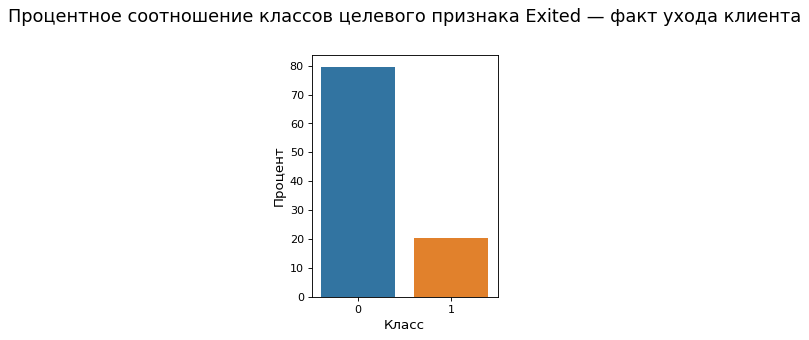

In [8]:
# Plot
plt.figure(figsize=(3,4), dpi= 80)
sns.barplot(x="Exited", y="Exited", data=churn, estimator=lambda x: len(x) / len(churn) * 100)

# Decorations
plt.title('Процентное соотношение классов целевого признака Exited — факт ухода клиента', fontsize=16, pad=30)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Процент', fontsize=12)

plt.show()

<div style="border:solid black 1.5px; padding: 20px">

- Из графика видно, что на класс "0" приходится 80% данных, на класс "1" - 20%, это говорит о дисбалансе классов в предоставленной выборке

<div style="border:solid black 1.5px; padding: 20px">

- Принимая во внимание явный дисбаланс классов целевого признака, мы можем воспользоваться следующими стратегиями при обучении модели:
    
    
    1. Использовать стратифицированную кросс-валидацию 
    
    2. Использовать весовые функции - наименнее представленному классу присвоить больший вес
    
    3. Добавить данных, относящихся к наименнее представленому классу, с помощью upsampling или наоборот уменьшить количество данных превосходящего класса - downsampling

<div style="border:solid black 1.5px; padding: 20px">


- Перед началом исследования зададим значение генератора псевдослучаных значений

In [9]:
random_state = 12345

<div style="border:solid black 1.5px; padding: 20px">


- Разобъем данные на две выборки в стандартном соотношении - обучающую (80%),  и тестовую (20%)

In [10]:
df_train, df_test = train_test_split(churn, test_size=0.2, random_state=random_state)

print()
print('----- Обучающая выборка: -----')
print()
df_train.info()

print()
print('----- Тестовая выборка: -----')
print()
df_test.info()


----- Обучающая выборка: -----

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 454 to 4578
Data columns (total 12 columns):
CreditScore          8000 non-null int64
Age                  8000 non-null int64
Tenure               8000 non-null int64
Balance              8000 non-null float64
NumOfProducts        8000 non-null int64
HasCrCard            8000 non-null int64
IsActiveMember       8000 non-null int64
EstimatedSalary      8000 non-null float64
Exited               8000 non-null int64
Geography_Germany    8000 non-null uint8
Geography_Spain      8000 non-null uint8
Gender_Male          8000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 648.4 KB

----- Тестовая выборка: -----

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 7867 to 694
Data columns (total 12 columns):
CreditScore          2000 non-null int64
Age                  2000 non-null int64
Tenure               2000 non-null int64
Balance              2000 non-null f

In [11]:
display(df_train[numerical_columns])

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
454,758,39,6,127357.76,1,0,1,56577.00
8307,618,30,3,133844.22,1,1,1,31406.93
4811,575,26,7,0.00,2,1,0,112507.63
1132,628,37,0,0.00,2,1,1,171707.93
9640,750,35,3,0.00,1,1,0,191520.50
...,...,...,...,...,...,...,...,...
4478,549,31,4,0.00,2,0,1,25684.85
4094,513,29,10,0.00,2,0,1,25514.77
3492,655,45,0,57327.04,1,0,1,47349.00
2177,667,24,4,0.00,2,0,1,34335.55


<div style="border:solid black 1.5px; padding: 20px">

    
- Поскольку количественные признаки имеют разную размерность и порядок величин, их необходимо масштабировать
    
    
- Зададим диапазон изменения признаков от 0 до 1

In [12]:
warnings.filterwarnings('ignore')

scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(df_train[numerical_columns]) 

df_train[numerical_columns] = scaler.transform(df_train[numerical_columns])
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns])

display(df_train[numerical_columns])

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
454,0.816,0.283784,0.6,0.507608,0.000000,0.0,1.0,0.282854
8307,0.536,0.162162,0.3,0.533460,0.000000,1.0,1.0,0.156992
4811,0.450,0.108108,0.7,0.000000,0.333333,1.0,0.0,0.562534
1132,0.556,0.256757,0.0,0.000000,0.333333,1.0,1.0,0.858564
9640,0.800,0.229730,0.3,0.000000,0.000000,1.0,0.0,0.957636
...,...,...,...,...,...,...,...,...
4478,0.398,0.175676,0.4,0.000000,0.333333,0.0,1.0,0.128379
4094,0.326,0.148649,1.0,0.000000,0.333333,0.0,1.0,0.127528
3492,0.610,0.364865,0.0,0.228487,0.000000,0.0,1.0,0.236710
2177,0.634,0.081081,0.4,0.000000,0.333333,0.0,1.0,0.171636


In [13]:
train_features = df_train.drop(['Exited'], axis=1)
train_target = df_train['Exited']

test_features = df_test.drop(['Exited'], axis=1)
test_target = df_test['Exited']

<div style="border:solid black 1.5px; padding: 20px">

    
## 2. Исследование модели без учета дисбаланса классов

<div style="border:solid black 1.5px; padding: 20px">

- В случае обучения модели при дисбалансе классов воспользуемся кросс-валидацией
    
    
- Для кросс-валидации обучающей выборки используем алгоритм стратифицированной выборки, т.е. в каждой группе распределение классов будет схожим, чтобы в одну из групп не попало слишком много значений одного класса
    
    
- Общая оценка точности будет рассчитываться как среднее значение по каждой группе


- Количество групп в кросс-валидации выберем равным 5 

In [14]:
cv = StratifiedShuffleSplit(n_splits=5, random_state=random_state)

<div style="border:solid black 1.5px; padding: 20px">

### Модель: случайный лес 

<div style="border:solid black 1.5px; padding: 20px">

- Зададим модель случайный лес без каких-либо весов для классов

In [15]:
random_forest_model = RandomForestClassifier(random_state=random_state, class_weight=None)

<div style="border:solid black 1.5px; padding: 20px">

- Рассмотрим параметры заданной модели

In [16]:
random_forest_model.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

<div style="border:solid black 1.5px; padding: 20px">

- Зададим параметры для подбора

In [17]:
random_forest_parameters_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1, 100, 10),
    'max_features' : ['auto', 'sqrt', 'log2', None],
    'min_samples_leaf' :  range(1, 20),
    'n_estimators' :  range(1, 100, 10)
}
 

<div style="border:solid black 1.5px; padding: 20px">


- Модель "случайный лес" за счет использования большого количества независимых деревьев является достаточно ресурсозатратной


- Чтобы сократить время поиска оптимальных параметров по заданному гриду, воспользуемся подходом randomized search, позволяющим отбросить значения параметров при которых достигается заведомо низкая точность модели

In [18]:
random_forest_random_grid_cv = RandomizedSearchCV(random_forest_model, random_forest_parameters_grid, n_iter=40, scoring='f1', cv=cv)

In [19]:
%%time
warnings.filterwarnings('ignore')

random_forest_random_grid_cv.fit(train_features, train_target)

CPU times: user 1min 54s, sys: 204 ms, total: 1min 54s
Wall time: 1min 54s


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=12345, test_size=None,
            train_size=None),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_...
                                                    random_state=12345,
                                          

In [20]:
print('Значение метрики f1 наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:', random_forest_random_grid_cv.best_score_)
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:')
print()
print(random_forest_random_grid_cv.best_params_)

Значение метрики f1 наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV: 0.5754871648199007

Параметры для наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:

{'n_estimators': 21, 'min_samples_leaf': 7, 'max_features': None, 'max_depth': 81, 'criterion': 'gini'}


<div style="border:solid black 1.5px; padding: 20px">

- Дополнительно сравним модель со случайной и оценим метрику AUC-ROC для разных выборок при кросс-валидации

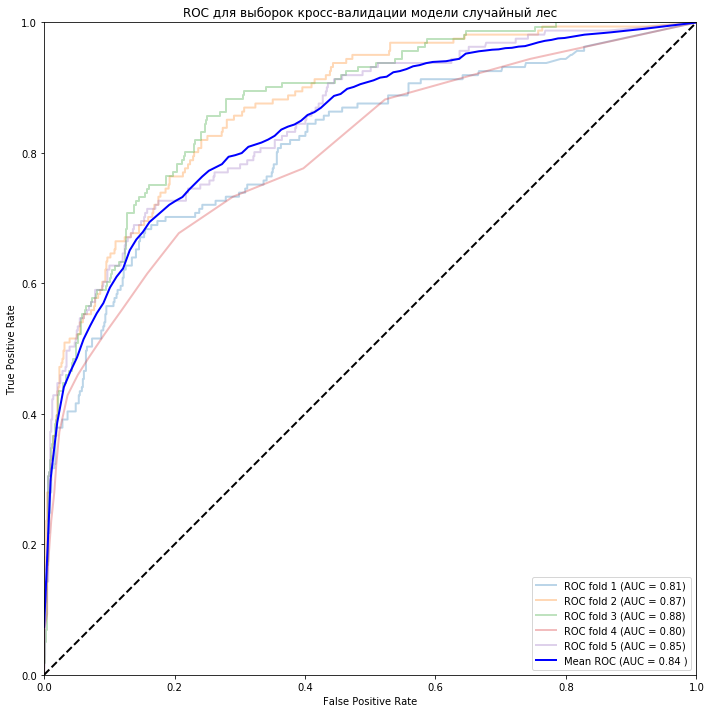

In [21]:
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(train_features, train_target):
    prediction = random_forest_random_grid_cv.fit(train_features.iloc[train],train_target.iloc[train]).predict_proba(train_features.iloc[test])
    fpr, tpr, t = roc_curve(train_target.iloc[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1   
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC для выборок кросс-валидации модели случайный лес')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

<div style="border:solid black 1.5px; padding: 20px">

- Значение метрики f1 немного меньше порога 0.59
    

- Среднее значение метрики AUC-ROC достаточно высокое   
    
    
- Сравним с результатами моделей с учетом дисбаланса классов
    

- В случае недостижения удовлетворительных значений метрики попробуем изменить гиперпараметры или исследуем другие модели

# 3. Борьба с дисбалансом

<div style="border:solid black 1.5px; padding: 20px">

### Модель: случайный лес с весами

<div style="border:solid black 1.5px; padding: 20px">

- Попробуем провести аналогичное исследование, но в этот раз будем использовать модель случайного леса с весовой функцией - в зависимости от частоты класса ему будет присваиваться соответсвующий вес

In [22]:
random_forest_model = RandomForestClassifier(random_state=random_state, class_weight='balanced')

In [23]:
random_forest_parameters_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1, 100, 10),
    'max_features' : ['auto', 'sqrt', 'log2', None],
    'min_samples_leaf' :  range(1, 20),
    'n_estimators' :  range(1, 100, 10)
}

In [24]:
random_forest_random_grid_cv = RandomizedSearchCV(random_forest_model, random_forest_parameters_grid, n_iter=40, scoring='f1', cv=cv)

In [25]:
%%time
warnings.filterwarnings('ignore')

random_forest_random_grid_cv.fit(train_features, train_target)

CPU times: user 2min 48s, sys: 212 ms, total: 2min 48s
Wall time: 2min 49s


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=12345, test_size=None,
            train_size=None),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=...
                                                    random_state=12345,
                                                    verbose=0,
                                

In [26]:
print('Значение метрики f1 наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:', random_forest_random_grid_cv.best_score_)
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:')
print()
print(random_forest_random_grid_cv.best_params_)

Значение метрики f1 наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV: 0.604763661075696

Параметры для наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:

{'n_estimators': 21, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 81, 'criterion': 'entropy'}


<div style="border:solid black 1.5px; padding: 20px">


- Дополнительно сравним модель со случайной и оценим метрику AUC-ROC для разных выборок при кросс-валидации


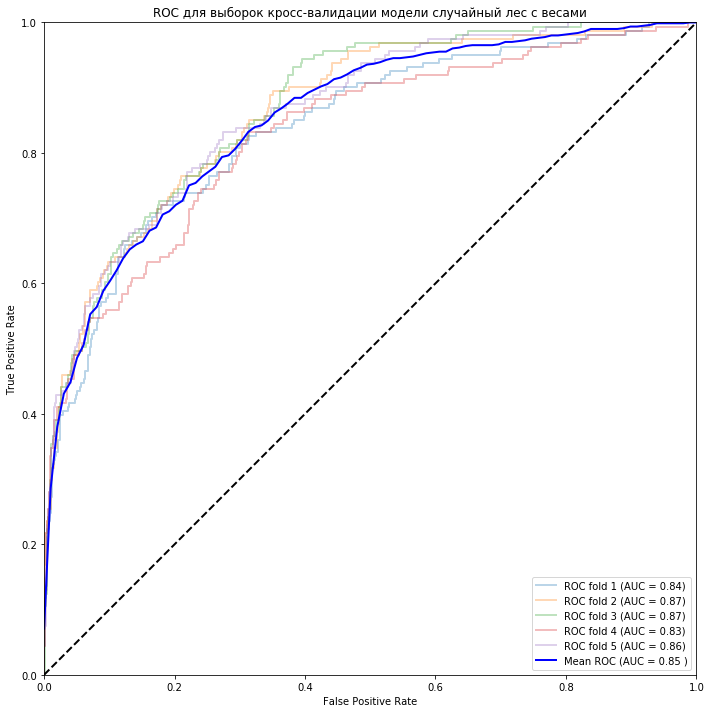

In [27]:
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(train_features, train_target):
    prediction = random_forest_random_grid_cv.fit(train_features.iloc[train],train_target.iloc[train]).predict_proba(train_features.iloc[test])
    fpr, tpr, t = roc_curve(train_target.iloc[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1   
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC для выборок кросс-валидации модели случайный лес с весами')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

<div style="border:solid black 1.5px; padding: 20px">

- Значение метрики f1 выше порога 0.59
    
    
- Добавление весовой функции для классов повысило значение метрики f1
    
    
- Среднее значение метрики AUC-ROC достаточно высокое

<div style="border:solid black 1.5px; padding: 20px">

### Модель: случайный лес по выборке после upsampling

<div style="border:solid black 1.5px; padding: 20px">

- Помимо балансировки классов весами, мы можем преобразовать обучающую выборку таким образом, чтобы увеличить количество данных наименее представленного класса

<div style="border:solid black 1.5px; padding: 20px">

- Введем функцию upsample, которая с помощью копирования добавит данных класса 1

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=random_state)
    
    return features_upsampled, target_upsampled


<div style="border:solid black 1.5px; padding: 20px">

- Выделим из тестовой выборки валидационную, т.к. при upsampling валидация должна проходить по выборке без искажения

In [32]:
train_features_before_upsample, valid_features, train_target_before_upsample, valid_target = train_test_split(train_features, train_target, test_size=0.25, random_state=random_state)

In [33]:
train_features_upsample, train_target_upsample = upsample(train_features_before_upsample, train_target_before_upsample, 4)

<div style="border:solid black 1.5px; padding: 20px">

- Подберем оптимальные параметры для модели

In [36]:
best_result = 0
best_model = 0

for n_estimators in range(1, 100, 20):
    for max_depth in range(1, 100, 20):

        random_forest_model = RandomForestClassifier(random_state=random_state, criterion='entropy', max_depth=max_depth, max_features='log2', min_samples_leaf=1, n_estimators=n_estimators)

        random_forest_model.fit(train_features_upsample, train_target_upsample)
        predicted = random_forest_model.predict(valid_features)

        random_forest_upsample_result = f1_score(valid_target, predicted)
        
        if random_forest_upsample_result>best_result:
            best_result = random_forest_upsample_result
            best_model = random_forest_model

In [37]:
print('Значение метрики f1 наилучшей модели на валидационной выборке:', best_result)
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке:')
print()
print(best_model)

Значение метрики f1 наилучшей модели на валидационной выборке: 0.6016483516483516

Параметры для наилучшей модели на кросс-валидационной выборке:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=21, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=61,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


<div style="border:solid black 1.5px; padding: 20px">

- Дополнительно сравним модель со случайной и оценим метрику AUC-ROC

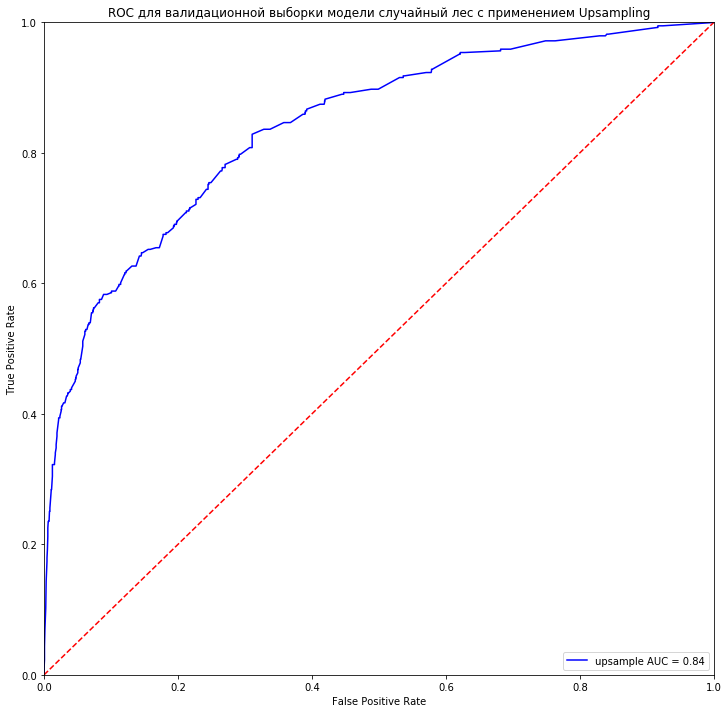

In [44]:
fig1 = plt.figure(figsize=[12,12])

probs = best_model.predict_proba(valid_features)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(valid_target, preds)
roc_auc_upsampling = auc(fpr, tpr)
plt.plot(fpr, tpr, 'Blue', label = 'upsample AUC = %0.2f' % roc_auc_upsampling)


# method I: plt
plt.title('ROC для валидационной выборки модели случайный лес с применением Upsampling')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<div style="border:solid black 1.5px; padding: 20px">

- Значение метрики f1 удовлетворительное
    
- Значение метрики AUC-ROC достаточно высокое   

<div style="border:solid black 1.5px; padding: 20px">

### Модель: случайный лес по выборке после downsampling

<div style="border:solid black 1.5px; padding: 20px">

- Аналогично мы можем преобразовать обучающую выборку таким образом, чтобы уменьшить количество данных наиболее представленного класса

<div style="border:solid black 1.5px; padding: 20px">

- Введем функцию downsample

In [45]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [46]:
train_features_downsample, train_target_downsample = downsample(train_features, train_target, 0.25)

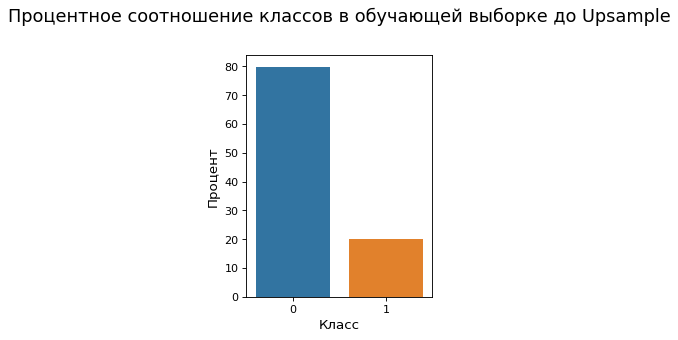

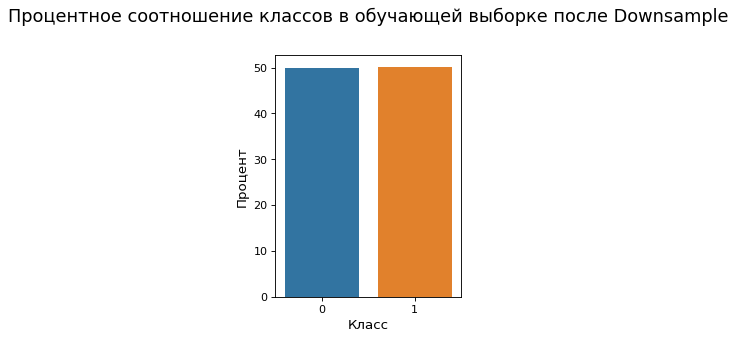

In [47]:
df_train_target = pd.DataFrame(train_target)
plt.figure(figsize=(3,4), dpi= 80)
sns.barplot(x="Exited", y="Exited", data=df_train_target, estimator=lambda x: len(x) / len(df_train_target) * 100)

plt.title('Процентное соотношение классов в обучающей выборке до Upsample', fontsize=16, pad=30)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Процент', fontsize=12)

plt.show()


df_train_target_downsample = pd.DataFrame(train_target_downsample)
plt.figure(figsize=(3,4), dpi= 80)
sns.barplot(x="Exited", y="Exited", data=df_train_target_downsample, estimator=lambda x: len(x) / len(df_train_target_downsample) * 100)

plt.title('Процентное соотношение классов в обучающей выборке после Downsample', fontsize=16, pad=30)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Процент', fontsize=12)

plt.show()

<div style="border:solid black 1.5px; padding: 20px">

- Балансировка классов прошла успешно

In [48]:
random_forest_model = RandomForestClassifier(random_state=random_state)

In [49]:
random_forest_parameters_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1, 100, 10),
    'max_features' : ['auto', 'sqrt', 'log2', None],
    'min_samples_leaf' :  range(1, 20),
    'n_estimators' :  range(1, 100, 10)
}

In [50]:
random_forest_random_grid_cv = RandomizedSearchCV(random_forest_model, random_forest_parameters_grid, n_iter=40, scoring='f1', cv=cv)

In [51]:
%%time
warnings.filterwarnings('ignore')

random_forest_random_grid_cv.fit(train_features_downsample, train_target_downsample)

CPU times: user 48.9 s, sys: 172 ms, total: 49 s
Wall time: 49.2 s


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=12345, test_size=None,
            train_size=None),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_...
                                                    random_state=12345,
                                          

In [52]:
print('Значение метрики f1 наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:', random_forest_random_grid_cv.best_score_)
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:')
print()
print(random_forest_random_grid_cv.best_params_)

Значение метрики f1 наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV: 0.7738269917217286

Параметры для наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:

{'n_estimators': 71, 'min_samples_leaf': 18, 'max_features': 'auto', 'max_depth': 61, 'criterion': 'entropy'}


<div style="border:solid black 1.5px; padding: 20px">

- Дополнительно сравним модель со случайной и оценим метрику AUC-ROC для разных выборок при кросс-валидации


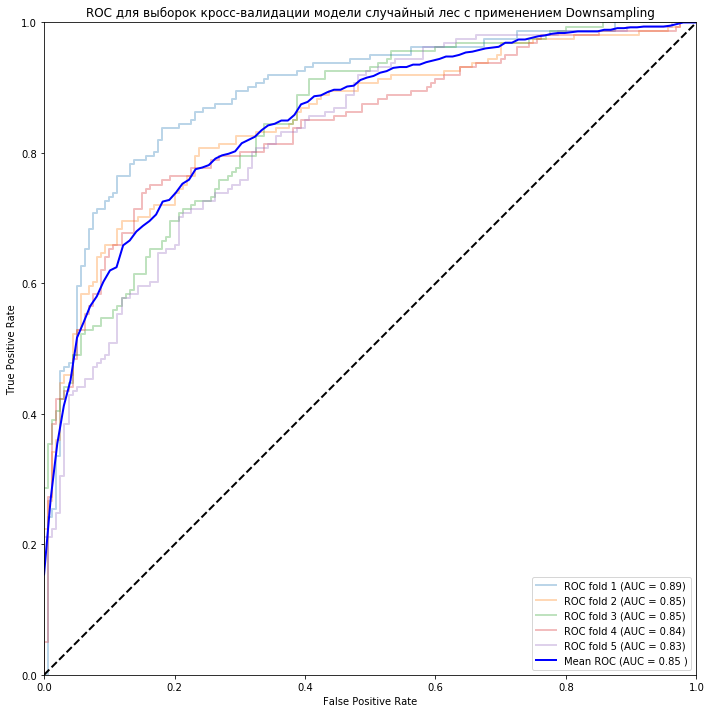

In [53]:
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(train_features_downsample, train_target_downsample):
    prediction = random_forest_random_grid_cv.fit(train_features_downsample.iloc[train],train_target_downsample.iloc[train]).predict_proba(train_features_downsample.iloc[test])
    fpr, tpr, t = roc_curve(train_target_downsample.iloc[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1   
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC для выборок кросс-валидации модели случайный лес с применением Downsampling')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

<div style="border:solid black 1.5px; padding: 20px">

- Значение метрики f1 достаточно большое
   
    
- При этом, стоит помнить, что от уменьшения количества данных модель могла хуже обучиться
    
    
- Среднее значение метрики AUC-ROC достаточно высокое   


# 4. Тестирование модели

<div style="border:solid black 1.5px; padding: 20px">
    
- Перейдем к проверке моделей на тестовой выборке

<div style="border:solid black 1.5px; padding: 20px">
    
#### Модель: случайный лес 

In [54]:
%%time

random_forest_model = RandomForestClassifier(random_state=random_state, criterion='entropy', max_depth=61, max_features=None, min_samples_leaf=1, n_estimators=51)

random_forest_model.fit(train_features, train_target)
predicted = random_forest_model.predict(test_features)

random_forest_result = f1_score(test_target, predicted)
print("---- Мера f1 модели случайный лес на тестовой выборке:", random_forest_result, '----')

---- Мера f1 модели случайный лес на тестовой выборке: 0.5656565656565656 ----
CPU times: user 1.97 s, sys: 3.99 ms, total: 1.98 s
Wall time: 1.99 s


<div style="border:solid black 1.5px; padding: 20px">
    
#### Модель: случайный лес с весами

In [55]:
%%time

random_forest_weights_model = RandomForestClassifier(random_state=random_state, criterion='gini', max_depth=71, max_features=None, min_samples_leaf=8, n_estimators=81, class_weight='balanced')

random_forest_weights_model.fit(train_features, train_target)
predicted = random_forest_weights_model.predict(test_features)

random_forest_weights_result = f1_score(test_target, predicted)
print("---- Мера f1 модели случайный лес с весами на тестовой выборке:", random_forest_weights_result, '----')

---- Мера f1 модели случайный лес с весами на тестовой выборке: 0.6354285714285715 ----
CPU times: user 2.18 s, sys: 8.01 ms, total: 2.18 s
Wall time: 2.19 s


<div style="border:solid black 1.5px; padding: 20px">
    
#### Модель: случайный лес по выборке после upsampling

In [56]:
%%time

random_forest_upsample_model = RandomForestClassifier(random_state=random_state, criterion='entropy', max_depth=91, max_features='log2', min_samples_leaf=1, n_estimators=61)

random_forest_upsample_model.fit(train_features_upsample, train_target_upsample)
predicted = random_forest_upsample_model.predict(test_features)

random_forest_upsample_result = f1_score(test_target, predicted)
print("---- Мера f1 модели случайный лес по выборке с Upsample на тестовой выборке:", random_forest_upsample_result, '----')

---- Мера f1 модели случайный лес по выборке с Upsample на тестовой выборке: 0.605830164765526 ----
CPU times: user 1.15 s, sys: 8 ms, total: 1.16 s
Wall time: 1.17 s


<div style="border:solid black 1.5px; padding: 20px">
    
#### Модель: случайный лес по выборке после downsampling

In [57]:
%%time

random_forest_downsample_model = RandomForestClassifier(random_state=random_state, criterion='gini', max_depth=41, max_features='log2', min_samples_leaf=3, n_estimators=51)

random_forest_downsample_model.fit(train_features_downsample, train_target_downsample)
predicted = random_forest_downsample_model.predict(test_features)

random_forest_downsample_result = f1_score(test_target, predicted)
print("---- Мера f1 модели случайный лес по выборке с Downsample на тестовой выборке:", random_forest_downsample_result, '----')

---- Мера f1 модели случайный лес по выборке с Downsample на тестовой выборке: 0.6060054595086443 ----
CPU times: user 291 ms, sys: 3 µs, total: 291 ms
Wall time: 305 ms


<div style="border:solid black 1.5px; padding: 20px">

- Наивысшая мера f1 достигается моделью случайный лес с весами   
    
    
- Дополнительно оценим насколько модели отличаются от случайной, для этого посчитаем метрику AUC-ROC и построим графики

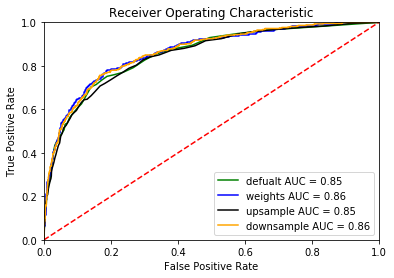

In [58]:
probs = random_forest_model.predict_proba(test_features)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_target, preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'defualt AUC = %0.2f' % roc_auc)

probs = random_forest_weights_model.predict_proba(test_features)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_target, preds)
roc_auc_weights = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'weights AUC = %0.2f' % roc_auc_weights)

probs = random_forest_upsample_model.predict_proba(test_features)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_target, preds)
roc_auc_upsampling = auc(fpr, tpr)
plt.plot(fpr, tpr, 'black', label = 'upsample AUC = %0.2f' % roc_auc_upsampling)

probs = random_forest_downsample_model.predict_proba(test_features)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_target, preds)
roc_auc_downsampling = auc(fpr, tpr)
plt.plot(fpr, tpr, 'orange', label = 'downsample AUC = %0.2f' % roc_auc_downsampling)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<div style="border:solid black 1.5px; padding: 20px">

- Мера AUC-ROC для всех моделей достаточно высокая и не сильно варьируется в зависимости от выбранной модели

In [60]:
d = {'Модель': ['Случайный лес', 'Случайный лес с весами', 'Случайный лес по выборке после upsampling', 'Случайный лес по выборке после downsampling'], 
     'Мера f1': [random_forest_result, random_forest_weights_result, random_forest_upsample_result, random_forest_downsample_result],
     'Качество меры f1' : ['неудовлетворительное', 'высокое', 'среднее', 'среднее'],
     'Мера AUC-ROC' : [roc_auc, roc_auc_weights, roc_auc_upsampling, roc_auc_downsampling]
    }

model_results = pd.DataFrame(data=d)

display(model_results.set_index('Модель').sort_values(by='Мера f1', ascending=False).round(3))

,Мера f1,Качество меры f1,Мера AUC-ROC
Модель,,,
Случайный лес с весами,0.635,высокое,0.864
Случайный лес по выборке после downsampling,0.606,среднее,0.864
Случайный лес по выборке после upsampling,0.606,среднее,0.850
Случайный лес,0.566,неудовлетворительное,0.854


# 5. Общий вывод

<div style="border:solid black 1.5px; padding: 20px">

    1. Часть исходных признаков не имеют отношения к вероятности ухода клиента из банка, поэтому в обучении модели не были использованы
    
    
    2. В исходных данных наблюдается дисбаланс классов в соотношении 80% - класс "0", 20% - класс "1"
    
    
    3. Блыи изучены модели "случайный лес" с учетом дисбаланса классов и без него
    
    
    4. Для учета баланса классов были опробованы три подхода: веса, upsampling и downsampling
    
    
    5. Модель случайный лес без учета дисбаланса показала неудовлетворительные результаты меры f1 = 0.566
    
    
    6. Модель случайный лес с учетом дисбаланса с помощью весов показала наивысший результат меры f1 = 0.635
    
    
    7. Мера AUC-ROC для всех моделей достаточно высокая и не сильно варьируется в зависимости от выбранной модели